# Changing the prompt

This notebook presents the comparison of results obtained by modifying the prompt (ChatGPT-Q vs. ChatGPT-Q-stepwise). It refer to section 6.3 of the paper.


In [10]:
import re
import json
from analysis import Analysis, guesser_vs_oracle_update, stepwise_guesser_annotations
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from collections import defaultdict 
from IPython.display import HTML
import nltk

plt.rcParams.update({'font.size': 13})
sns.set_style("darkgrid")

## Load data

In [11]:
with open("../data/generation/8_mcrae/dialogues.txt") as f:
     dialogues_8_mcrae = f.read()
with open("../data/generation/8_mcrae/oracle_annotations.json") as f:
     oracle_annotations_8_mcrae = json.load(f)
with open("../data/generation/8_mcrae/guesser_annotations.json") as f:
     guesser_annotations_8_mcrae = json.load(f)
analysis_8_mcrae = Analysis(dialogues_8_mcrae, oracle_annotations_8_mcrae, "8_mcrae")


with open("../data/generation/8_mcrae_stepwise/dialogues.txt") as f:
     dialogues_8_mcrae_stepwise = f.read()
with open("../data/generation/8_mcrae_stepwise/oracle_annotations.json") as f:
     oracle_annotations_8_mcrae_stepwise = json.load(f)
guesser_annotations_8_mcrae_stepwise = stepwise_guesser_annotations(dialogues_8_mcrae_stepwise)
analysis_8_mcrae_stepwise = Analysis(dialogues_8_mcrae_stepwise, oracle_annotations_8_mcrae_stepwise, "8_mcrae_stepwise")

## Information-Seeking Strategy

<Axes: title={'center': 'Distance from optimal agent per turn'}, xlabel='Turn', ylabel='EIG Distance'>

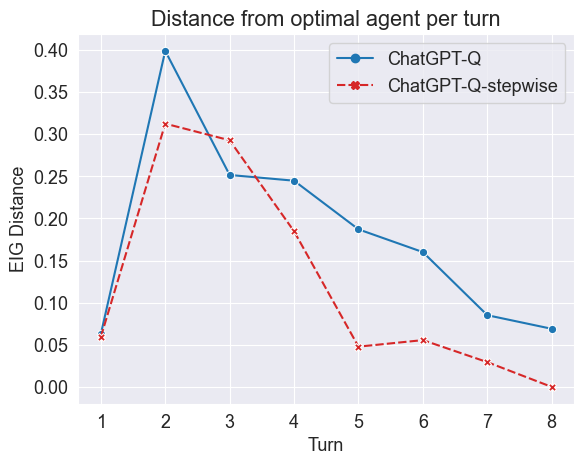

In [12]:
ig_per_turn = analysis_8_mcrae.compute_eig() 
eig_8_mcrae = [(np.mean(ig_per_turn["optimal"][i]) - np.mean(ig_per_turn["model"][i])) for i in range(8)]

ig_per_turn = analysis_8_mcrae_stepwise.compute_eig() 
eig_8_mcrae_stepwise = [(np.mean(ig_per_turn["optimal"][i]) - np.mean(ig_per_turn["model"][i])) for i in range(8)]

df = pd.DataFrame(
    {
        "ChatGPT-Q" : eig_8_mcrae,
        "ChatGPT-Q-stepwise" : eig_8_mcrae_stepwise
    }
)
df.index = range(1,9)
palette = {"ChatGPT-Q": "tab:blue", "ChatGPT-Q-stepwise": "tab:red"}
plt.title("Distance from optimal agent per turn")
plt.xlabel('Turn')
plt.ylabel('EIG Distance')
sns.lineplot(df, markers=True, palette=palette)

## Hypothesis Space update

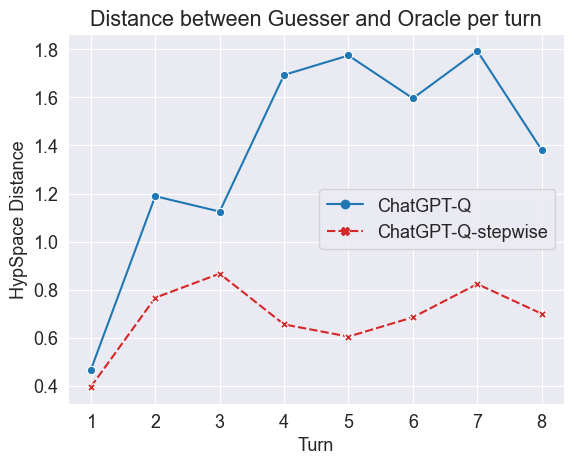

In [13]:
correcteness_8_mcrae, distance_8_mcrae = guesser_vs_oracle_update(guesser_annotations_8_mcrae, oracle_annotations_8_mcrae)
correcteness_8_mcrae_stepwise, distance_8_mcrae_stepwise = guesser_vs_oracle_update(guesser_annotations_8_mcrae_stepwise, oracle_annotations_8_mcrae_stepwise)

df = pd.DataFrame(
    {
        "ChatGPT-Q" : [np.mean(distance_8_mcrae[i]) for i in range(1,9)],
        "ChatGPT-Q-stepwise" : [np.mean(distance_8_mcrae_stepwise[i]) for i in range(1,9)]
    }
)
df.index = range(1,9)

palette = {"ChatGPT-Q": "tab:blue", "ChatGPT-Q-stepwise": "tab:red"}
fig = sns.lineplot(df, palette=palette, markers=True)
plt.title("Distance between Guesser and Oracle per turn")
plt.xlabel("Turn")
plt.ylabel("HypSpace Distance")
plt.show(fig)

## Search Efficiency

##### Number of questions per game

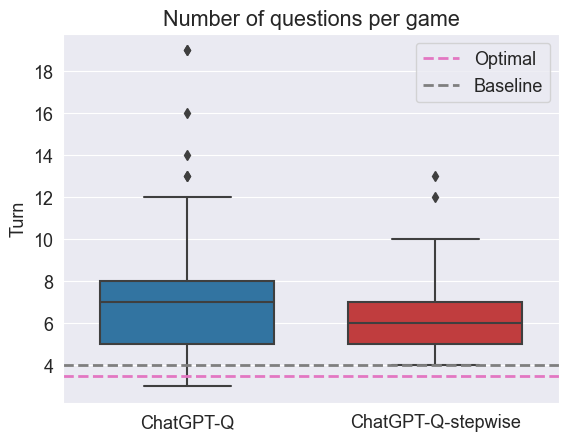

In [16]:
_ = analysis_8_mcrae.average_questions()
_ = analysis_8_mcrae_stepwise.average_questions()


df = pd.DataFrame(
    {
        "ChatGPT-Q" : analysis_8_mcrae.questions_dist,
        "ChatGPT-Q-stepwise" : analysis_8_mcrae_stepwise.questions_dist
    }
)

palette = {"ChatGPT-Q": "tab:blue", "ChatGPT-Q-stepwise": "tab:red"}
sns.boxplot(df, palette=palette, width=0.7)
plt.axhline((np.log2(analysis_8_mcrae.num_candidates)+0.5), color='tab:pink', linestyle='dashed', linewidth=2, label='Optimal')
plt.axhline((analysis_8_mcrae.num_candidates/2), color='tab:gray', linestyle='dashed', linewidth=2, label="Baseline")
plt.title("Number of questions per game")
plt.ylabel("Turn")
plt.legend()
plt.show()

##### Unnecessary questions

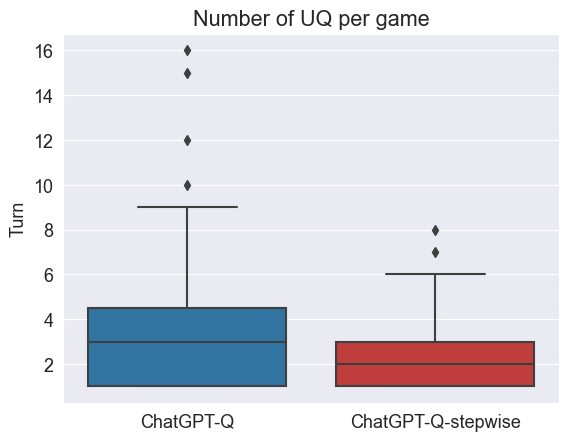

In [15]:
unnecessary_qs_8_mcrae, percentage_unnecessary_dial, percentage_unnecessary_qs = analysis_8_mcrae.unnecessary_questions()
unnecessary_qs_8_mcrae_stepwise, percentage_unnecessary_dial, percentage_unnecessary_qs = analysis_8_mcrae_stepwise.unnecessary_questions()


sns.boxplot([unnecessary_qs_8_mcrae, unnecessary_qs_8_mcrae_stepwise], palette=["tab:blue", "tab:red"])
plt.xticks([0, 1], ["ChatGPT-Q", "ChatGPT-Q-stepwise"])
plt.title("Number of UQ per game")
plt.ylabel("Turn")
plt.show()